# Data Imbalance - Health Insurance

_By: Francisco da Ana (up202108762)_

For this assignement related to **Imbalaced Data**, I will be using the Health Insurance dataset already explored in the first and second assignements (Data Profiling & Data Complexity).

From the suggested tasks for this assignement, I chose the project **B**: 
> "Perform a case study on imbalanced learning ... You can start by profiling your data and decide on which
performance metric(s) to optimize ... Then, select a few classification methods ...  Finally, apply different techniques for addressing the class imbalance issue"

First, let's remember the dataset characteristics and the main objective of the dataset:

It contains 15 attributes (1 target and 14 features) and 72458 instances. The target variable is `health_ins`, which is a binary feature that indicates if the individual has health insurance or not. The dataset contains both numerical and categorical features.

The attributes are:
- _`unnamed`_ | **numeric**: an index column
- `custid` | **text**: the unique ID of the customer
- `sex` | **categorical**: the gender of the customer
- `is_employed` | **boolean**: indicates whether the customer is employed or not
- `income` | **numeric**: numerical value representing the customer's income
- `marital_status` | **categorical**: the marital status of the customer
- `health_ins` | **boolean**: indicates whether the customer has health insurance or not. This can be the target variable in the context of a classification problem.
- `housing_type` | **categorical**: describes the situation of the customer's habitation
- `num_vehicles` | **numeric**: the number of vehicles the customer owns
- `age` | **numeric**: the age of the customer in years
- `state_of_res` | **text**: the US state where the customer resides
- `code_column` | **numeric**: likely a categorical or code-based feature (potentially related to location or demographics).
- `gas_usage` | **numeric**: a measure of the customer's gas usage
- `rooms` | **numeric**: the number of rooms in the customer's house
- `recent_move_b` | **boolean**: indicator if the customer has recently moved

In [27]:
X = df.drop('health_ins', axis=1)
y = df['health_ins']

In [29]:
c1 = round(pbx.c1(X,y),3)
c1

In [176]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
import problexity.classification as pbx
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.feature_selection import RFE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import BorderlineSMOTE
from IPython.display import Image

## Remembering the previous analysis

In a first step of this assignement, I will remember the main conclusions from the previous assignements and then I will proceed with the analysis of the impact of the data imbalance in the classification task.

### Data Profiling & Preprocessing

In [3]:
df = pd.read_csv('data.csv')
df.head()

In [5]:
# 'Unnamed: 0', 'custid' must be removed
df = df.drop(['Unnamed: 0', 'custid'], axis=1)
df.shape

Now let's treat the missing values.

In [6]:
df.isnull().sum()

In [7]:
df['is_employed'].value_counts(dropna=False)

In [8]:
# NaN values for 'is_employed' mean people who are not in the workforce. They will be treated as not employed.
df['is_employed'] = df['is_employed'].fillna(0)
df['is_employed'].value_counts(dropna=False)

In [9]:
num = df[df.isnull().any(axis=1)].shape[0]
print(print(f'{num} rows have missing values. \nApprox. {num/df.shape[0]*100:.2f}% of the orignal dataset.'))

In [10]:
# The rows with missing values are all the same. They will be removed.
df = df.dropna()
df.shape

There are also redundant columns like `code_column`, which encodes the `state_of_res` column. We can remove one of them. I prefer to keep the `state_of_res` column and then enconde it to numerical values with 1 unit of difference between each state.

In [12]:
max(df.groupby('state_of_res')['code_column'].nunique())

In [13]:
df.drop('code_column', axis=1, inplace=True)
df.shape

Another issue is the presence of outliers for variables `age`, `income` and `gas_usage`.

In [14]:
# For variable 'age', truncate values to 21-99. Values outside this range will be replaced to th closest endpoint.
print(f'Max age: {df['age'].max()} | Min age: {df['age'].min()}')
df['age'] = df['age'].clip(lower=21, upper=99)
print(f'Max age: {df['age'].max()} | Min age: {df['age'].min()}')
print(df.shape)

In [20]:
# scale age feature to 0-1 and round to 2 decimal places (people with similar ages will be grouped together)
scaler = MinMaxScaler()
df['age'] = scaler.fit_transform(df[['age']]).round(2)
df['age'].describe()

In [23]:
# 'income' and 'gas_usage' will be scaled to a normal distribution
scaler = StandardScaler()
df[['income', 'gas_usage']] = scaler.fit_transform(df[['income', 'gas_usage']])
df[['income', 'gas_usage']].describe()

In [24]:
df.head(10)

Categorical columns must be encoded to numerical values.

In [25]:
encoder = LabelEncoder()
cat_columns = ['sex', 'is_employed', 'marital_status', 'health_ins', 'housing_type', 'state_of_res', 'recent_move_b']

for col in cat_columns:
    df[col] = encoder.fit_transform(df[col])

df.head(10)

Is the data prepared to be used in the classification task? Well, let's take a last look... on the target variable.

In [26]:
print(df['health_ins'].value_counts()/df.shape[0]*100)
positive_cases = df[df['health_ins'] == 1].shape[0]
negative_cases = df[df['health_ins'] == 0].shape[0]
print(f'Imbalance ratio: {round(positive_cases/negative_cases)}')

In [4]:
print(f'{len(df.columns)} columns: {df.columns}')

One of the problems we identified in the first assignement was the presence of unique identifiers in the dataset, such as the `custid` and _`unnamed`_ columns. These columns are not relevant for the analysis and should be removed, since they are not useful for finding patterns in the data.

Our target variable is highly imbalanced, with a IR of around 10. Data complexity measure "Entropy of class proportions" is 0.561. A value like this for a binary classification problem indicates a considerable level of class imbalance that may require techniques to address the imbalance and ensure the model's performance is robust across both classes.

### Performance of some classifiers

Before treating the imbalance issue, let's apply 2 simple classifiers to the dataset and check their performance metrics. We will use the following classifiers:
- Decision Tree
- K-Nearest Neighbors

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

For this dataset, in the previous assignement we verified the best performance metrics (F1 score) is achieved for the following hyperparameters:
- **Decision Tree**: max_depth=5
- **K-Nearest Neighbors**: n_neighbors=20

In [32]:
dec_tree = DecisionTreeClassifier(max_depth=5)
dec_tree.fit(X_train, y_train)

y_pred = dec_tree.predict(X_test)
acc = round(accuracy_score(y_test, y_pred),4)
f1 = round(f1_score(y_test, y_pred),4)
print(f'Accuracy: {acc} | F1: {f1}')

This seems very good! Accuracy rounds 91% and F1 95%. But let's see the confusion matrix.

In [33]:
cm_dec_tree = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dec_tree)
disp.plot()

tp, tn, fp, fn = cm_dec_tree[1,1], cm_dec_tree[0,0], cm_dec_tree[0,1], cm_dec_tree[1,0]
print(f'TP: {tp} | TN: {tn} | FP: {fp} | FN: {fn}')

In [34]:
len(y_pred)

21232

The performance metrics are very misleading. The model is absolutely biased towards the majority class.
It basically classifies all cases as positive.

From the whole training set (21.232 cases), it only classified 4 case as negative... and it still failed on all of them. The testing process resulted in absolutely 0 true negatives.

What if we we don't limit the tree's depth? Will the model overfit?

In [35]:
dec_tree_no_pruning = DecisionTreeClassifier()
dec_tree_no_pruning.fit(X_train, y_train)

y_pred = dec_tree_no_pruning.predict(X_test)
acc = round(accuracy_score(y_test, y_pred),4)
f1 = round(f1_score(y_test, y_pred),4)
print(f'Accuracy: {acc} | F1: {f1}')

Accuracy: 0.8489 | F1: 0.9164


Worse performance...?

TP: 17579 | TN: 444 | FP: 1471 | FN: 1738


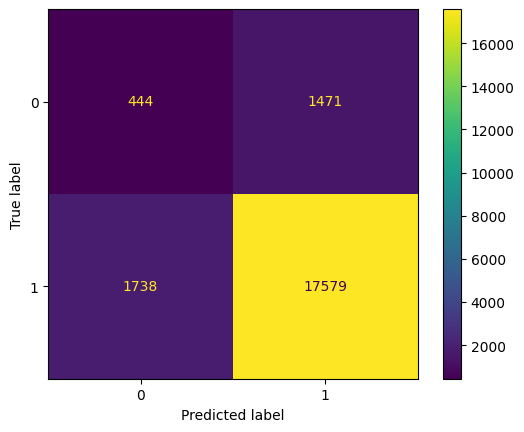

In [36]:
cm_dec_tree_no_pruning = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dec_tree_no_pruning)
disp.plot()

tp, tn, fp, fn = cm_dec_tree_no_pruning[1,1], cm_dec_tree_no_pruning[0,0], cm_dec_tree_no_pruning[0,1], cm_dec_tree_no_pruning[1,0]
print(f'TP: {tp} | TN: {tn} | FP: {fp} | FN: {fn}')

Even with lower metrics, the "overfitted" decision tree is more able of capturiing the minority class. There were 451 true negatives in the testing process, which is a huge improvement on the "optimized" tree, besides the lower accuracy and F1 score.

How will a KNN classifier perform?

In [37]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
acc = round(accuracy_score(y_test, y_pred),4)
f1 = round(f1_score(y_test, y_pred),4)
print(f'Accuracy: {acc} | F1: {f1}')

Accuracy: 0.9095 | F1: 0.9525


Same values for accuracy and F1...

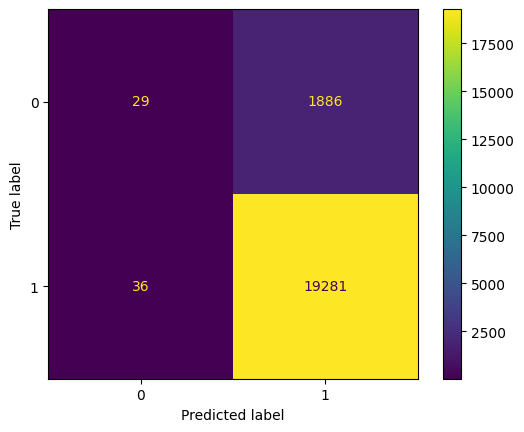

In [38]:
cm_knn = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn)
disp.plot()

tp, tn, fp, fn = cm_knn[1,1], cm_knn[0,0], cm_knn[0,1], cm_knn[1,0]

This model is a bit better than the optimized decision tree when it comes to the minority class. However, the improvement (4 true negatives to 29) is not very significant, considering the size of the dataset.

What if we reduce the number of neighbors to 5?

In [40]:
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5.fit(X_train, y_train)

y_pred = knn_5.predict(X_test)
acc = round(accuracy_score(y_test, y_pred),4)
f1 = round(f1_score(y_test, y_pred),4)
print(f'Accuracy: {acc} | F1: {f1}')

Accuracy: 0.901 | F1: 0.9476


TP: 19008 | TN: 123 | FP: 1792 | FN: 309


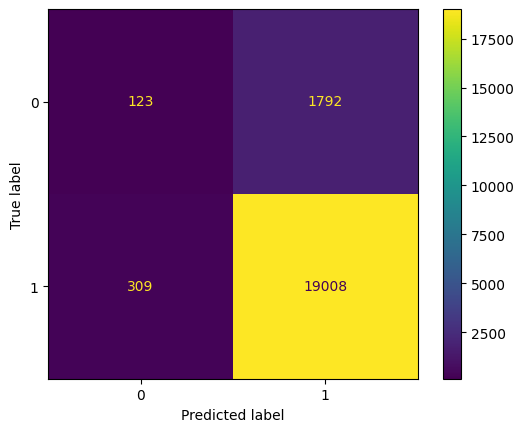

In [41]:
cm_knn_5 = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn_5)
disp.plot()

tp, tn, fp, fn = cm_knn_5[1,1], cm_knn_5[0,0], cm_knn_5[0,1], cm_knn_5[1,0]
print(f'TP: {tp} | TN: {tn} | FP: {fp} | FN: {fn}')

KNN classifier shows very ineteresting insights. Theoretically, it achieves better performance for k=20, but this is, again, a misleading metric. The more neighbors it considers, the more underfitted the model becomes and the more biased towards the majority class it gets. And, since the training set is very imbalanced, the model will better predict the majority class.

This is the proof that an "overfitted" model may be better for caputring the minority class in an imbalanced dataset.

## Dealing with the imbalance issue

To deal with the high imbalance in the dataset, we will apply some techniques that can be interpreted as:
- Data-level
- Algorithm-level
- Cost-sensitive
- Feature-level

### Feature-level techniques
One useful approach for dealing with sensible datasets is reducing the number of features by excluding the less relevant ones. This can be done by using feature selection techniques, such as Recursive Feature Elimination (RFE).

In [77]:
rfe = RFE(estimator=dec_tree_no_pruning, n_features_to_select=6)
rfe = rfe.fit(X_train, y_train)

# summarize the selection of the attributes
all = zip(X_train.columns,  rfe.ranking_)

for feature,rank in sorted(all, key=lambda x: x[1]):
    print(f'{feature}: {rank}')

income: 1
num_vehicles: 1
age: 1
state_of_res: 1
gas_usage: 1
rooms: 1
marital_status: 2
housing_type: 3
recent_move_b: 4
is_employed: 5
sex: 6


In [78]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)
X_train_rfe.shape

(49539, 6)

Now we're going to use T-NSE to visualize the dataset in 2D and see if we can identify some insights. This is important because there are many variants of other techniques that can be chosen accordingly to the dataset's characteristics.

In [83]:
# T-NSE for visualization
tsne = TSNE(n_components=2, random_state=42)
print("Fitting for reduced dataset")
X_tsne_rfe = tsne.fit_transform(X_train_rfe)
print("Fitting for original dataset")
X_tsne_original = tsne.fit_transform(X_train)

Fitting for reduced dataset
Fitting for original dataset


In [ ]:
# save datasets in tsne/ folder
np.save('tsne/X_tsne_rfe.npy', X_tsne_rfe)
np.save('tsne/X_tsne_original.npy', X_tsne_original)

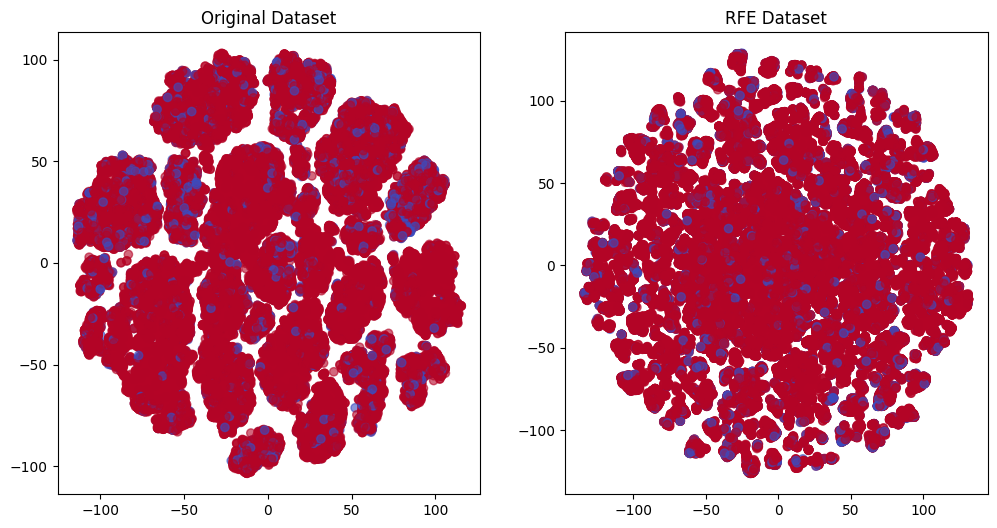

In [84]:
# plot the T-NSE for the original dataset and the RFE dataset
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_tsne_original[:,0], X_tsne_original[:,1], c=y_train, cmap='coolwarm', alpha=0.6)
plt.title('Original Dataset')
plt.subplot(1, 2, 2)
plt.scatter(X_tsne_rfe[:,0], X_tsne_rfe[:,1], c=y_train, cmap='coolwarm', alpha=0.6)
plt.title('RFE Dataset')
plt.show()

- The original dataset shows a clear clustering of the data points, indicating that the original set of features was able to capture underlying structure in the data. The clusters appear well-separated, suggesting the features were informative for distinguishing between different groups or categories.

- However, the RFE (Recursive Feature Elimination) dataset plot shows the data points are much more dispersed and less clearly clustered.

- One possible interpretation is that the RFE process has removed important features that were crucial for separating the different groups in the data. The dataset lost some descriminative power when compared to the original dataset.

Due to this analysis, we won't consider the dataset derived from the RFE process for the classification task.

### Data-level techniques
These techniques can be summarized in 2 concepts: undersampling and oversampling.
These are methods which, respectively, remove examples of the majority class and generate samples for the minority class in order to balance the dataset. They will be applied to the training set only, to avoid data leakage and keep data integrity.

The classical approach to put this in practice is **SMOTE** (Synthetic Minority Over-sampling Technique). This technique generates synthetic samples for any instances of the the minority class by interpolating between existing samples. This is a very popular technique for dealing with imbalanced datasets.

There are several variations of SMOTE, that can be chosen according to the dataset's characteristics. Looking at the 2D representation of our datasete, we can already reason about some of these variations.

- **Classic SMOTE**: the original SMOTE algorithm, which generates synthetic samples along the line connecting two existing samples. Does not seem a very good choice for this dataset, since the data points are not very close to each other. This is a too simplistic approach for this dataset.
- **Borderline SMOTE**: a variation of SMOTE that generates synthetic samples near the decision boundary between classes. Although this seems a promising idea, the dataset does not show a clear decision boundary, which may make this technique less effective.
- **ADASYN**: this approach generates synthetic samples based on the density of the minority class. It focuses on the samples that are harder to classify, leaving the easier ones untouched. Looking at the plot, there are not many "easy" samples to classify (all of them are quite mixed with the majority class), which may make this technique less effective.
- **SMOTE-TL**: this is a more advanced version of SMOTE that considers the presence of noisy samples from the majority class in the generation of synthetic samples. It removes the borderline instances between the minority and majority classes using Tomek links to improve the decision boundaries.
- **SMOTE-ENN**: this is another advanced SMOTE version that combines both over-sampling and under-sampling. It uses the Edited Nearest Neighbors (ENN) algorithm to remove noisy samples from the majority class and then applies SMOTE to generate synthetic samples for the minority class.

Due to the high overlap between classes and the lack of a clear decision boundary, we will apply the **SMOTE-ENN** technique to the dataset. This seems the most promising approach for this dataset, as it combines the benefits of both over-sampling and under-sampling to improve the decision boundaries and reduce the impact of noisy samples.

In [101]:
smote_enn = SMOTEENN(random_state=42)
X_resampled_smoteenn, y_resampled_smoteenn = smote_enn.fit_resample(X_train, y_train)
print(f'Original dataset: {y_train.value_counts()/len(y_train)*100}')
print(f'Resampled dataset: {y_resampled_smoteenn.value_counts()/len(y_resampled_smoteenn)*100}')

Original dataset: health_ins
1    90.879913
0     9.120087
Name: count, dtype: float64
Resampled dataset: health_ins
0    57.896396
1    42.103604
Name: count, dtype: float64


Instead of a 90/10 ration, the applied technique generated a 58/42 ratio. Event it is not a perfect balance, it is a significant improvement and we can consider this dataset as balanced.

What is the aspect of the data distribution after applying the SMOTE-ENN technique?

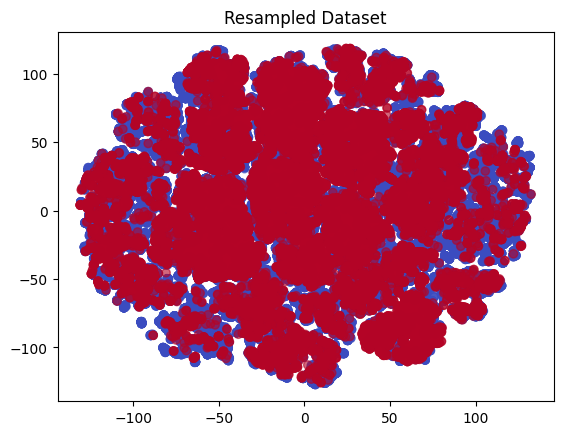

In [128]:
# This code takes a long time to run. The results are saved in SMOTE-ENN.png
"""
X_train_resampled_tsne_smoteenn = tsne.fit_transform(X_resampled_smoteenn)
np.save('tsne/smoteenn_tsne.npy', X_train_resampled_tsne_smoteenn)

plt.scatter(X_train_resampled_tsne_smoteenn[:,0], X_train_resampled_tsne_smoteenn[:,1], c=y_resampled_smoteenn, cmap='coolwarm', alpha=0.6)
plt.title('Resampled Dataset')
plt.show()
"""
Image('SMOTE-ENN.png')

The representation shows a clearer boundary between the two classes, which indicates that the SMOTE-ENN technique was able to improve the separation between the classes. Can a border-line technique enhance this separation even more? We will apply Borderline SMOTE to the dataset generated by SMOTE-ENN.

In [108]:
borderline_smote = BorderlineSMOTE(random_state=42)
X_resampled_borderline, y_resampled_borderline = borderline_smote.fit_resample(X_resampled_smoteenn, y_resampled_smoteenn)
print(f'SMOTEENN dataset: {y_resampled_smoteenn.value_counts()/len(y_resampled_smoteenn)*100}')
print(f'Borderline SMOTE dataset: {y_resampled_borderline.value_counts()/len(y_resampled_borderline)*100}'))

SMOTEENN dataset: health_ins
0    57.896396
1    42.103604
Name: count, dtype: float64
Borderline SMOTE dataset: health_ins
0    50.0
1    50.0
Name: count, dtype: float64


In [112]:
print(f'Number of samples in the Borderline SMOTE dataset: {len(y_resampled_borderline)}: {len(y_resampled_borderline)/len(y_train)*100:.2f}% of the original dataset.')
print(y_resampled_borderline.value_counts())

Number of samples in the Borderline SMOTE dataset: 84472: 170.52% of the original dataset.
health_ins
0    42236
1    42236
Name: count, dtype: int64


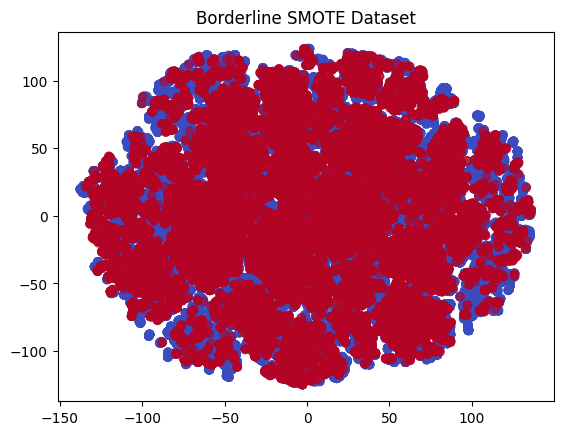

In [129]:
# This code takes a long time to run. The results are saved in SMOTE-ENN-BORDERLINE.png
"""
X_train_resampled_tsne_borderline = tsne.fit_transform(X_resampled_borderline)
np.save('tsne/borderline_tsne.npy', X_train_resampled_tsne_borderline)

plt.scatter(X_train_resampled_tsne_borderline[:,0], X_train_resampled_tsne_borderline[:,1], c=y_resampled_borderline, cmap='coolwarm', alpha=0.6)
plt.title('Borderline SMOTE Dataset')
plt.show()
"""
Image('SMOTE-ENN-BORDERLINE.png')

I'm curious to see the difference to a SMOTE-TL technique. Let's apply it and compare the results.

In [104]:
smote_tomek = SMOTETomek(random_state=42)
X_resampled_smotetomek, y_resampled_smotetomek = smote_tomek.fit_resample(X_train, y_train)
print(f'Original dataset: {y_train.value_counts()/len(y_train)*100}')
print(f'Resampled dataset: {y_resampled_smotetomek.value_counts()/len(y_resampled_smotetomek)*100}')

Original dataset: health_ins
1    90.879913
0     9.120087
Name: count, dtype: float64
Resampled dataset: health_ins
1    50.0
0    50.0
Name: count, dtype: float64


This technique generated a 50/50 ratio, which is a perfect balance. This is a very good result, but it may be a bit too optimistic. The dataset is now perfectly balanced, but it may have lost some information in the process. Let's see the 2D representation of the dataset.

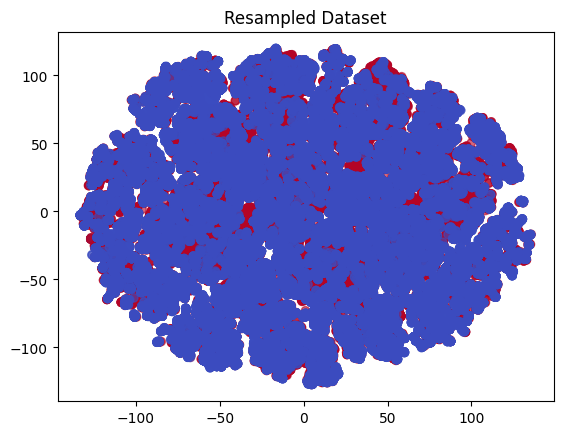

In [130]:
# This code takes a long time to run. The results are saved in SMOTE-TL.png
"""
X_train_resampled_tsne_smotetomek = tsne.fit_transform(X_resampled_smotetomek)
np.save('tsne/smotetomek_tsne.npy', X_train_resampled_tsne_smotetomek)

plt.scatter(X_train_resampled_tsne_smotetomek[:,0], X_train_resampled_tsne_smotetomek[:,1], c=y_resampled_smotetomek, cmap='coolwarm', alpha=0.6)
plt.title('Resampled Dataset')
plt.show()
"""
Image('SMOTE-TL.png')

Analysing these datasets by the 2D representation may lead to misleading conclusions. Let's evaluate the feature-based metrics for the 3 datasets and compare the results.

In [115]:
datasets = {
    'original': (X_train, y_train),
    'smoteenn': (X_resampled_smoteenn, y_resampled_smoteenn),
    'borderline': (X_resampled_borderline, y_resampled_borderline),
    'smotetomek': (X_resampled_smotetomek, y_resampled_smotetomek)
}

fb_measures = pd.DataFrame([], columns=['dataset', 'f1', 'f2', 'f3', 'f4'])

for dataset, (X, y) in datasets.items():
    print(f'Calculating for {dataset}')
    f1 = round(pbx.f1(X, y),3)
    f2 = round(pbx.f2(X, y),3)
    f3 = round(pbx.f3(X, y),3)
    f4 = round(pbx.f4(X, y),3)
    fb_measures.loc[len(fb_measures)] = [dataset, f1, f2, f3, f4]

fb_measures

Calculating for original
Calculating for smoteenn
Calculating for borderline
Calculating for smotetomek


,dataset,f1,f2,f3,f4
0,original,0.949,0.281,0.993,0.993
1,smoteenn,0.722,0.220,0.993,0.993
2,borderline,0.757,0.220,0.994,0.994
3,smotetomek,0.803,0.281,0.996,0.996


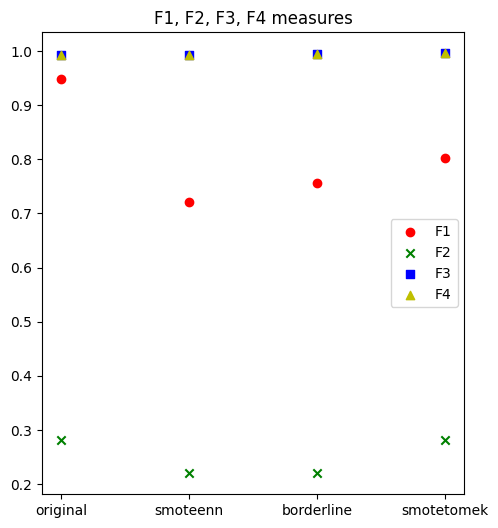

In [121]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(fb_measures['dataset'], fb_measures['f1'], color='r', label='F1', marker='o')
plt.scatter(fb_measures['dataset'], fb_measures['f2'], color='g', label='F2', marker='x')
plt.scatter(fb_measures['dataset'], fb_measures['f3'], color='b', label='F3', marker='s')
plt.scatter(fb_measures['dataset'], fb_measures['f4'], color='y', label='F4', marker='^')
plt.legend()
plt.title('F1, F2, F3, F4 measures')
plt.show()

Remembering the meaning of each measure:
- **F1**: class separability
- **F2**: feature overlap
- **F3**: best single feature
- **F4**: combined feature effectiveness

Looking at the results, the "best" datset is the original one. However, since this is a very imbalanced dataset, we can not trust this conclusion, because this dataset will lead to underfitted models, totally biased towards the majority class.

From the 3 balanced sets:
- **SMOTE-TL** has the highets class separability, but it is the worst in terms of feature overlap.
- **SMOTE-ENN** has the minimum feature overlap, but it is the worst in terms of class separability.
- **Borderline SMOTE** has the best feature overlap, just like SMOTE-ENN, and it's an intermediate in terms of class separability.

Considering the results, we will proceed with the **Borderline SMOTE** dataset for the classification task.

In [126]:
X_train = X_resampled_borderline
y_train = y_resampled_borderline

X_train.shape, y_train.value_counts()

((84472, 11),
 health_ins
 0    42236
 1    42236
 Name: count, dtype: int64)

### Algorithm-level techniques
Now we will apply the same classifiers to the balanced dataset, explore some hyperparameters and check the performance metrics.

For now, we will look at the 2 previous classifiers:
- Decision Tree
- K-Nearest Neighbors

In [150]:
dec_tree_measures = pd.DataFrame(columns=['max_depth', 'accuracy', 'f1', 'conf_matrix'])

max_depths = list(range(3, 35, 2)) + [None]
crit = 'gini'

for max_depth in max_depths:
    model = DecisionTreeClassifier(max_depth=max_depth, criterion=crit, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = round(accuracy_score(y_test, y_pred)*100,1)
    f1 = round(f1_score(y_test, y_pred)*100,1)
    cm = confusion_matrix(y_test, y_pred)
    dec_tree_measures.loc[len(dec_tree_measures)] = [max_depth, acc, f1, cm]

    print(f'max_depth: {max_depth}\taccuracy: {acc}\tf1: {f1}')

    if max_depth is None:
        print(model.tree_.max_depth)

dec_tree_measures

max_depth: 3	accuracy: 62.8	f1: 74.9
max_depth: 5	accuracy: 62.4	f1: 74.5
max_depth: 7	accuracy: 70.4	f1: 81.2
max_depth: 9	accuracy: 71.7	f1: 82.3
max_depth: 11	accuracy: 72.1	f1: 82.6
max_depth: 13	accuracy: 72.5	f1: 82.9
max_depth: 15	accuracy: 73.6	f1: 83.8
max_depth: 17	accuracy: 74.0	f1: 84.2
max_depth: 19	accuracy: 74.6	f1: 84.6
max_depth: 21	accuracy: 75.2	f1: 85.1
max_depth: 23	accuracy: 75.8	f1: 85.5
max_depth: 25	accuracy: 76.1	f1: 85.7
max_depth: 27	accuracy: 76.0	f1: 85.6
max_depth: 29	accuracy: 76.0	f1: 85.7
max_depth: 31	accuracy: 76.0	f1: 85.7
max_depth: 33	accuracy: 75.8	f1: 85.5
max_depth: None	accuracy: 76.0	f1: 85.7
35


,max_depth,accuracy,f1,conf_matrix
0,3,62.8,74.9,"[[1546, 369], [7522, 11795]]"
1,5,62.4,74.5,"[[1584, 331], [7647, 11670]]"
2,7,70.4,81.2,"[[1375, 540], [5743, 13574]]"
3,9,71.7,82.3,"[[1300, 615], [5391, 13926]]"
4,11,72.1,82.6,"[[1268, 647], [5272, 14045]]"
5,13,72.5,82.9,"[[1216, 699], [5149, 14168]]"
6,15,73.6,83.8,"[[1149, 766], [4845, 14472]]"
7,17,74.0,84.2,"[[1071, 844], [4669, 14648]]"
8,19,74.6,84.6,"[[1001, 914], [4475, 14842]]"
9,21,75.2,85.1,"[[946, 969], [4303, 15014]]"


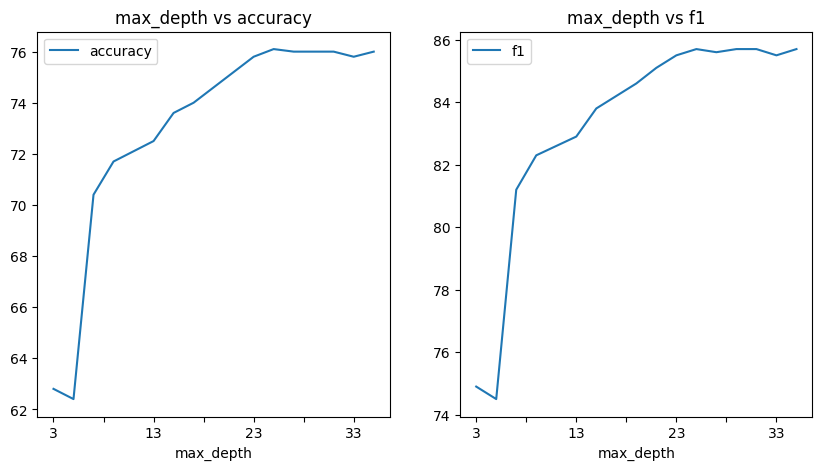

<Figure size 640x480 with 0 Axes>

In [151]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

dec_tree_measures.plot(x='max_depth', y='accuracy', ax=ax[0], title='max_depth vs accuracy')
dec_tree_measures.plot(x='max_depth', y='f1', ax=ax[1], title='max_depth vs f1')

plt.show()
plt.savefig('dec_tree_measures.png')

We can consider the best max_depth is 25. It's still considerably lower than the max_depth without any limit and achieves good performance metrics.

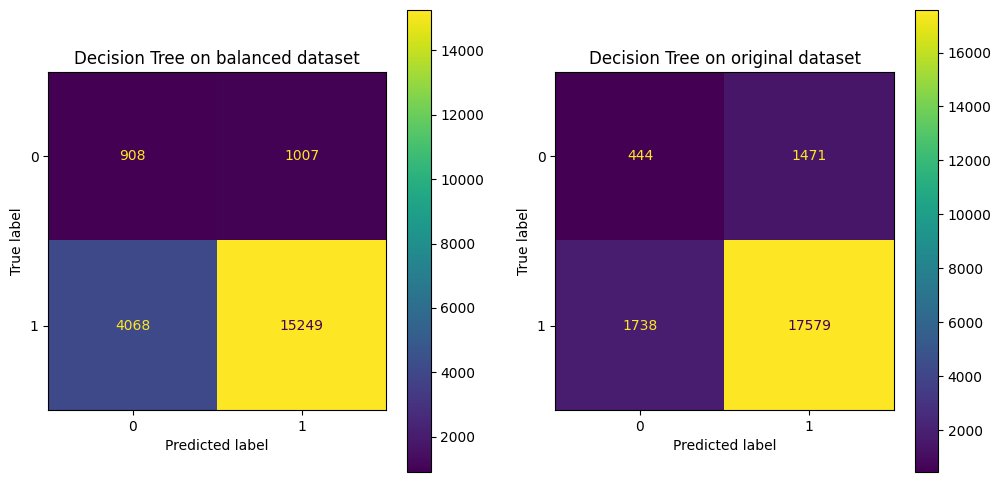

<Figure size 640x480 with 0 Axes>

In [159]:
cm_dec_tree_balanced = dec_tree_measures.loc[dec_tree_measures['max_depth'] == 25, 'conf_matrix'].values[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_dec_tree_balanced)
disp.plot(ax=ax1)
ax1.set_title('Decision Tree on balanced dataset')

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_dec_tree_no_pruning)
disp2.plot(ax=ax2)
ax2.set_title('Decision Tree on original dataset')

plt.show()
plt.savefig('dec_tree_cms.png')

We can see that this model has lower performance metrics than the original dataset. However, the model is now able to capture the minority class, which is a significant improvement. The F1 score is now 0.65, which is a considerable improvement over the original dataset.

In [161]:
knn_measures = pd.DataFrame(columns=['k', 'accuracy', 'f1', 'conf_matrix'])

n_neighbors = list(range(1, 50, 2))
dist_metric = 'minkowski'

for k in n_neighbors:
    model = KNeighborsClassifier(n_neighbors=k, metric=dist_metric)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = round(accuracy_score(y_test, y_pred)*100,1)
    f1 = round(f1_score(y_test, y_pred)*100,1)
    cm = confusion_matrix(y_test, y_pred)
    knn_measures.loc[len(knn_measures)] = [k, acc, f1, cm]

    print(f'k: {k}\taccuracy: {acc}\tf1: {f1}')

knn_measures

k: 1	accuracy: 70.4	f1: 81.7
k: 3	accuracy: 69.2	f1: 80.7
k: 5	accuracy: 68.6	f1: 80.2
k: 7	accuracy: 68.4	f1: 80.1
k: 9	accuracy: 68.0	f1: 79.7
k: 11	accuracy: 67.6	f1: 79.4
k: 13	accuracy: 67.5	f1: 79.3
k: 15	accuracy: 67.3	f1: 79.2
k: 17	accuracy: 66.9	f1: 78.8
k: 19	accuracy: 67.0	f1: 78.9
k: 21	accuracy: 66.8	f1: 78.7
k: 23	accuracy: 66.7	f1: 78.6
k: 25	accuracy: 66.4	f1: 78.3
k: 27	accuracy: 66.3	f1: 78.3
k: 29	accuracy: 66.1	f1: 78.2
k: 31	accuracy: 65.9	f1: 78.0
k: 33	accuracy: 65.7	f1: 77.8
k: 35	accuracy: 65.8	f1: 77.8
k: 37	accuracy: 65.6	f1: 77.7
k: 39	accuracy: 65.3	f1: 77.5
k: 41	accuracy: 65.3	f1: 77.4
k: 43	accuracy: 65.2	f1: 77.4
k: 45	accuracy: 65.1	f1: 77.2
k: 47	accuracy: 64.9	f1: 77.2
k: 49	accuracy: 64.9	f1: 77.1


,k,accuracy,f1,conf_matrix
0,1,70.4,81.7,"[[916, 999], [5283, 14034]]"
1,3,69.2,80.7,"[[982, 933], [5611, 13706]]"
2,5,68.6,80.2,"[[1031, 884], [5790, 13527]]"
3,7,68.4,80.1,"[[1050, 865], [5844, 13473]]"
4,9,68.0,79.7,"[[1064, 851], [5945, 13372]]"
5,11,67.6,79.4,"[[1079, 836], [6038, 13279]]"
6,13,67.5,79.3,"[[1106, 809], [6093, 13224]]"
7,15,67.3,79.2,"[[1111, 804], [6130, 13187]]"
8,17,66.9,78.8,"[[1131, 784], [6236, 13081]]"
9,19,67.0,78.9,"[[1140, 775], [6224, 13093]]"


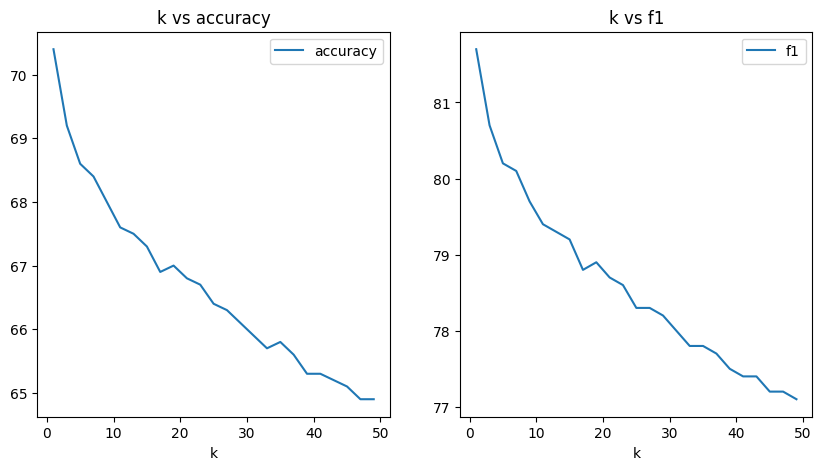

<Figure size 640x480 with 0 Axes>

In [162]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

knn_measures.plot(x='k', y='accuracy', ax=ax[0], title='k vs accuracy')
knn_measures.plot(x='k', y='f1', ax=ax[1], title='k vs f1')

plt.show()
plt.savefig('knn_measures.png')

Performance metrics decrease as the number of neighbors increases - model becomes too simple (underfitted) and biased towards the majority class.

We can consider a reasonable number of neighbors is 5.

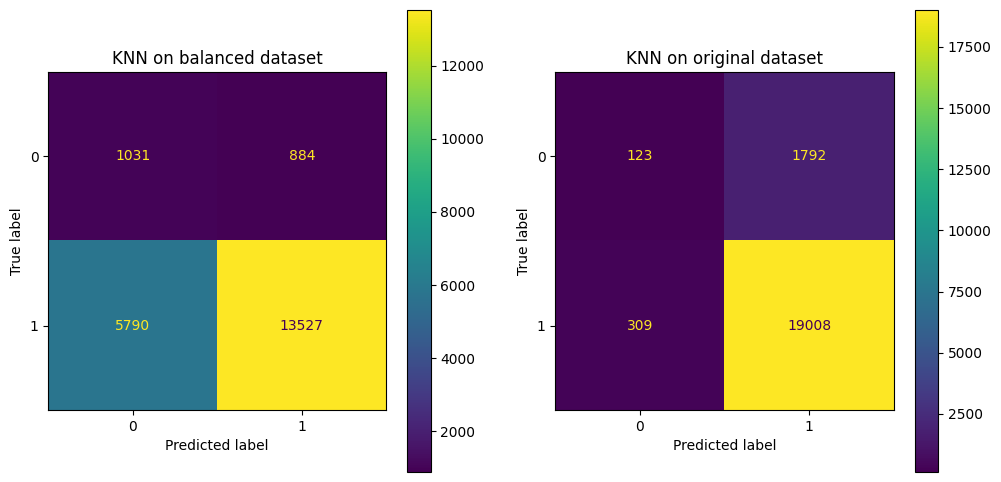

<Figure size 640x480 with 0 Axes>

In [164]:
cm_knn_balanced = knn_measures.loc[knn_measures['k'] == 5, 'conf_matrix'].values[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn_balanced)
disp.plot(ax=ax1)
ax1.set_title('KNN on balanced dataset')

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_knn_5)
disp2.plot(ax=ax2)
ax2.set_title('KNN on original dataset')

plt.show()
plt.savefig('knn_cms.png')

Why not to test a logistic regression model?

In [178]:
# Use grid search cv to find the best hyperparameters for logistic regression

params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'random_state': [42],
    'max_iter': [500]
}

log_reg = LogisticRegression()
grid = GridSearchCV(log_reg, params, cv=5, n_jobs=-1, scoring='f1')
grid.fit(X_train, y_train)

print(f'Best parameters: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

/Users/fpana/opt/anaconda3/envs/icd/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
80 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/fpana/opt/anaconda3/envs/icd/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/fpana/opt/anaconda3/envs/icd/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/fpana/opt/anaconda3/envs/icd/lib/pyth

Best parameters: {'C': 0.1, 'max_iter': 500, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear'}
Best score: 0.7238334676537426


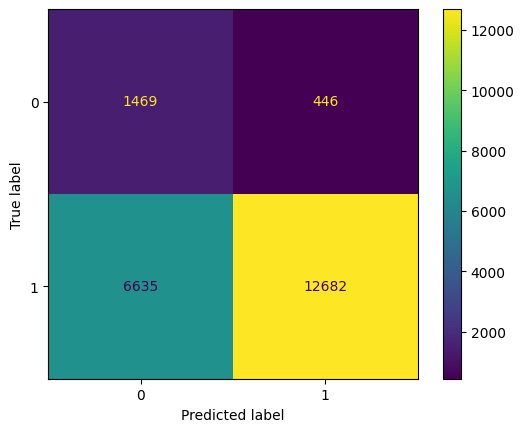

In [179]:
log_reg = LogisticRegression(**grid.best_params_)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
cm_lr_balanced = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr_balanced)
disp.plot()

### Coparison of the classifiers
Let's look at all performance metrics for the 3 classifiers and compare them.

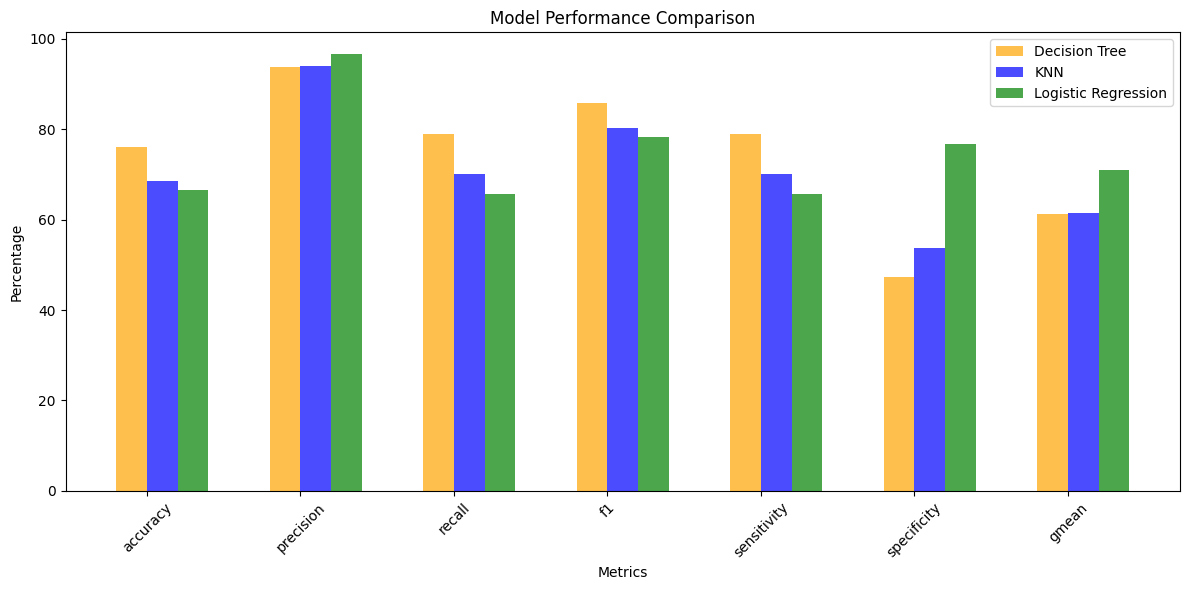

<Figure size 640x480 with 0 Axes>

In [180]:
cms = [cm_dec_tree_balanced, cm_knn_balanced, cm_lr_balanced]

metrics = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1', 'sensitivity', 'specificity', 'gmean'])

for cm in cms:
    tp, tn, fp, fn = cm[1,1], cm[0,0], cm[0,1], cm[1,0]
    acc = round((tp+tn)/(tp+tn+fp+fn)*100,1)
    prec = round(tp/(tp+fp)*100,1)
    rec = round(tp/(tp+fn)*100,1)
    f1 = round(2*prec*rec/(prec+rec),1)
    sensitivity = round(tp/(tp+fn)*100,1)
    specificity = round(tn/(tn+fp)*100,1)
    gmean = round(np.sqrt(sensitivity*specificity),1)

    if cm is cm_dec_tree_balanced:
        model = 'Decision Tree'
    elif cm is cm_knn_balanced:
        model = 'KNN'
    else:
        model = 'Logistic Regression'

    metrics.loc[len(metrics)] = [model, acc, prec, rec, f1, sensitivity, specificity, gmean]

# Plot metrics with side-by-side bars for Decision Tree and KNN
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# List of metrics to plot
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'sensitivity', 'specificity', 'gmean']

# Set the width of each bar and the positions
bar_width = 0.2
index = np.arange(len(metrics_to_plot))

# Plot Decision Tree bars
dt_values = metrics[metrics['model'] == 'Decision Tree'][metrics_to_plot].values[0]
knn_values = metrics[metrics['model'] == 'KNN'][metrics_to_plot].values[0]
log_reg_values = metrics[metrics['model'] == 'Logistic Regression'][metrics_to_plot].values[0]

plt.bar(index, dt_values, bar_width, label='Decision Tree', color='orange', alpha=0.7)
plt.bar(index + bar_width, knn_values, bar_width, label='KNN', color='blue', alpha=0.7)
plt.bar(index + 2*bar_width, log_reg_values, bar_width, label='Logistic Regression', color='green', alpha=0.7)

# Customizing the plot
plt.xlabel('Metrics')
plt.ylabel('Percentage')
plt.title('Model Performance Comparison')
plt.xticks(index + bar_width/2, metrics_to_plot, rotation=45)
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

- **Accuracy**: The proportion of total correct predictions (both true positives and true negatives) out of all predictions.

- **Precision**: The ratio of correctly predicted positive observations to the total predicted positive observations, measuring how many of the predicted positive cases are actually positive.

- **Recall**: The ratio of correctly predicted positive observations to all observations in the actual positive class, measuring how many of the actual positive cases were correctly identified.

- **F1 Score**: The harmonic mean of precision and recall, providing a single score that balances both metrics and works well for imbalanced datasets.

- **Sensitivity**: Identical to recall, representing the proportion of actual positive cases that were correctly identified (also known as the true positive rate).

- **Specificity**: The proportion of actual negative cases that were correctly identified, measuring how well the model can identify true negatives.

- **G-mean (Geometric Mean)**: A metric that calculates the geometric average of sensitivity and specificity, providing a balanced measure of a model's performance across both positive and negative classes.